<a href="https://colab.research.google.com/github/AmedeeRoy/BirdDL/blob/main/Dive_Prediction_MatrixDistance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Seabird Diving Behaviour with GPS data

Supervized Learning on Distance Matrix

In [2]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [3]:
%cd drive/My\ Drive/BirdDL

/content/drive/My Drive/BirdDL


In [72]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython
import datetime
import random
import pickle
import trip

In [73]:
# connect to database
conn = sqlite3.connect('/content/drive/My Drive/data/seabirdbank.db')

request = "SELECT \
            trip.id as trip, gps.datetime, gps.lon, gps.lat\
            FROM gps \
            INNER JOIN trip ON gps.trip = trip.id \
            INNER JOIN bird ON trip.bird = bird.id \
            WHERE trip.file_gps IS NOT NULL \
            AND trip.file_tdr IS NOT NULL \
            AND (bird.fieldwork = 'P1108' OR bird.fieldwork = 'P1111' \
                OR bird.fieldwork = 'P1112' OR bird.fieldwork = 'P1113') \
            AND bird.species = 'SV'"

# substr(bird.fieldwork,1,1) = 'P'

gps = pd.read_sql_query(request, conn)

# check duplicated datetime in GPS trip
idx = gps.index[gps.loc[:, 'trip':'datetime'].duplicated(keep=False)]
idx_drop = [idx[i] for i in range(0, len(idx), 2)]
gps = gps.drop(idx_drop)


request = "SELECT \
            trip.id as trip, tdr.datetime, tdr.pressure \
            FROM tdr \
            INNER JOIN trip ON tdr.trip = trip.id \
            INNER JOIN bird ON trip.bird = bird.id \
            WHERE trip.file_gps IS NOT NULL \
            AND trip.file_tdr IS NOT NULL \
            AND (bird.fieldwork = 'P1108' OR bird.fieldwork = 'P1111' \
                OR bird.fieldwork = 'P1112' OR bird.fieldwork = 'P1113') \
            AND bird.species = 'SV'"

# WHERE substr(bird.fieldwork,1,1) = 'P' 

tdr = pd.read_sql_query(request, conn)
tdr['datetime'] = pd.to_datetime(tdr['datetime'], format='%Y-%m-%d %H:%M:%S')
gps['datetime'] = pd.to_datetime(gps['datetime'], format='%Y-%m-%d %H:%M:%S')

df = pd.merge(tdr, gps, on=['trip', 'datetime'], how='left')

# check NaN and fill with interpolations
[i for i, x in enumerate(df['lon'].isna()) if x]


df['lon'] = df['lon'].interpolate(method='polynomial', order=2)
df['lat'] = df['lat'].interpolate(method='polynomial', order=2)


bad_trip = ['P1111_9_SV_T1', 'P1111_13_SV_T6', 'P1111_41_SV_T2', 'P1111_46_SV_T5', 'P1111_52_SV_T1',
            'P1112_4_SV_T2', 'P1112_26_SV_T5', 'P1112_36_SV_T1', 'P1112_36_SV_T2', 'P1113_41_SV_T3',
           'P1113_50_SV_T2']

no_loop = ['P1112_26_SV_T1', 'P1112_26_SV_T2', 'P1112_26_SV_T3', 'P1112_26_SV_T4']


### remove bad data
idx = df.index[[(t in bad_trip or t in no_loop) for t in df.trip]]
df = df.drop(idx)

df

,trip,datetime,pressure,lon,lat
0,P1108_4_SV_T1,2008-11-25 13:00:35,-0.35,-77.264128,-11.773317
1,P1108_4_SV_T1,2008-11-25 13:00:36,-0.38,-77.264118,-11.773235
2,P1108_4_SV_T1,2008-11-25 13:00:37,-0.35,-77.264098,-11.773152
3,P1108_4_SV_T1,2008-11-25 13:00:38,-0.29,-77.264113,-11.773060
4,P1108_4_SV_T1,2008-11-25 13:00:39,-0.29,-77.264142,-11.772955
...,...,...,...,...,...
1035988,P1113_50_SV_T1,2013-11-24 13:09:17,-1.01,-77.264229,-11.773601
1035989,P1113_50_SV_T1,2013-11-24 13:09:18,-1.07,-77.264221,-11.773701
1035990,P1113_50_SV_T1,2013-11-24 13:09:19,-1.07,-77.264191,-11.773771
1035991,P1113_50_SV_T1,2013-11-24 13:09:20,-1.01,-77.264168,-11.773826


In [74]:
%%time
trajs = []
threshold = 1
radius = 500
n = 1
for k in df.trip.unique():
    df_trip = df[df.trip == k]
    
    t = trip.Trip(df_trip)
    t.add_dive(threshold)

    trajs.append(t.df)
    
    IPython.display.clear_output(wait=True)
    print('Trip [{}/{}]'.format(n, len(df.trip.unique())))
    n+=1

Trip [170/170]
CPU times: user 18.8 s, sys: 264 ms, total: 19 s
Wall time: 19 s


In [75]:
test_trajs_idx = np.random.randint(0, len(df.trip.unique()), 30)

test_trajs = [trajs[i] for i in test_trajs_idx]
train_trajs = [trajs[i] for i in range(len(df.trip.unique())) if i not in test_trajs_idx]

## Neural Network

In [76]:
# pytorch materials
import torch
from torch import nn
from torch import optim
import torchvision as tv
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [156]:
class Sampler:
    def __init__(self, trajs, epoch, batch_size):
      # raw trajectories
      self.trajs = trajs
      self.n = len(trajs)

      # sample input specificities
      self.epoch = epoch
      self.batch_size = batch_size
      self.input_var = input_var

    def sample_one(self):
      # look for a long trip
      dt = []
      while len(dt) < epoch:
          traj_idx = np.random.randint(self.n)
          dt = self.trajs[traj_idx]

      # select part of this trip
      epoch_idx = np.random.randint(2, len(dt)-epoch)

      input_trajs = dt.loc[epoch_idx:epoch_idx+epoch-1, ('lon', 'lat')]
      output_trajs = dt.loc[epoch_idx:epoch_idx+epoch-1, 'dive']

      extract = trip.Trip(input_trajs)
      extract.compute_dist_matrix(verbose=False)

      # change resolution
      output = [np.max(output_trajs[i:i+11]) for i in range(len(output_trajs)) if i%10==0]

      return (extract.dist_matrix, np.array(output), np.array(input_trajs))


    def sample(self):
      input_batch = []
      output_batch = []
      for i in range(self.batch_size):
        
        (x,y,z) = self.sample_one()

        # add it to batch
        input_batch.append(x)
        output_batch.append(y)
      
      # convert to tensor
      input_batch = torch.FloatTensor(input_batch)
      output_batch = torch.FloatTensor(output_batch)

      return (input_batch, output_batch)

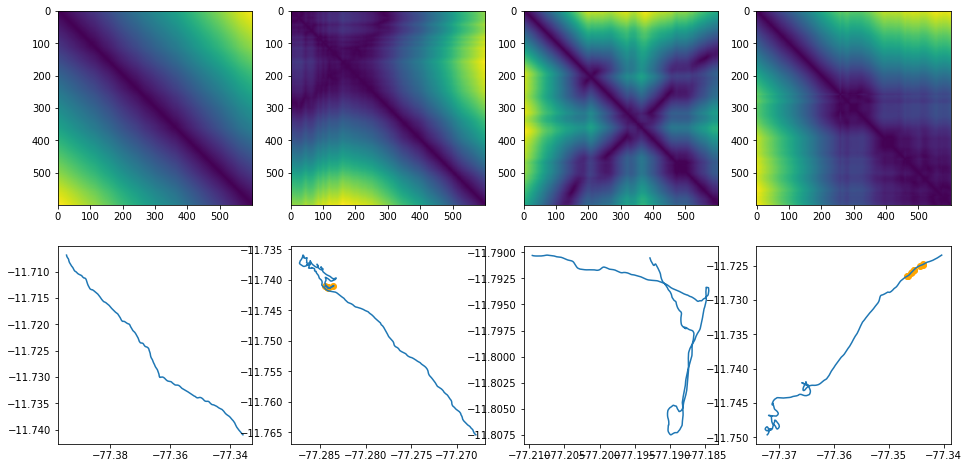

In [157]:
# Hyperparameters
epoch = 600
batch_size = 4
learning_rate = 0.01

train = Sampler(train_trajs, epoch, batch_size)
test = Sampler(test_trajs, epoch, batch_size)

plt.figure(figsize=(16, 8))

for i in range(4):
  (x, y, z) = train.sample_one()

  plt.subplot(2, 4, 1+i)
  plt.imshow(x)

  plt.subplot(2, 4, 5+i)
  plt.plot(z[:,0], z[:,1])
  plt.scatter(z[np.where(y),0], z[np.where(y),1], c='orange')

In [161]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.cnn_input_1 = nn.Sequential(
            nn.Conv1d(600, 600, kernel_size = 101, stride = 1, padding = 100, dilation = 2),
            nn.ReLU(),
            nn.Conv1d(600, 600, kernel_size = 51, stride = 1, padding = 50, dilation = 2),
            nn.ReLU(),
            nn.Conv1d(600, 600, kernel_size = 26, stride = 1, padding = 25, dilation = 2),
            nn.ReLU()
        )

        self.pooling_1 = nn.Sequential(
            nn.MaxPool1d(kernel_size = 50, stride = 2, padding = 24, dilation = 1)
        )

        self.cnn_input_2 = nn.Sequential(
            nn.Conv1d(8, 16, kernel_size = 51, stride = 1, padding = 50, dilation = 2),
            nn.ReLU(),
            nn.Conv1d(16, 16, kernel_size = 26, stride = 1, padding = 25, dilation = 2),
            nn.ReLU()
        )

        self.pooling_2 = nn.Sequential(
            nn.MaxPool1d(kernel_size = 15, stride = 2, padding = 7, dilation = 1)
        )

        self.cnn_input_3 = nn.Sequential(
            nn.Conv1d(16, 32, kernel_size = 26, stride = 1, padding = 25, dilation = 2),
            nn.ReLU(),
            nn.Conv1d(32, 32, kernel_size = 11, stride = 1, padding = 10, dilation = 2),
            nn.ReLU()
        )

        self.pooling_3 = nn.Sequential(
            nn.MaxPool1d(kernel_size = 15, stride = 2, padding = 5, dilation = 5)
        )

        self.cnn_4 = nn.Sequential(
            nn.Conv1d(32, 16, kernel_size = 26, stride = 1, padding = 25, dilation = 2),
            nn.ReLU(),
            nn.Conv1d(16, 8, kernel_size = 11, stride = 1, padding = 10, dilation = 2),
            nn.ReLU(),
            nn.Conv1d(8, 1, kernel_size = 6, stride = 1, padding = 5, dilation = 2),
            nn.Sigmoid()
        )
        
                
    def forward(self, x):
        out = self.cnn_input_1(x)
        out = self.pooling_1(out)
        out = self.cnn_input_2(out)
        out = self.pooling_2(out)
        out = self.cnn_input_3(out)
        out = self.pooling_3(out)
        out = self.cnn_4(out)

        return out.reshape((batch_size, 120))

In [158]:
x,y = train.sample()
x.size()

torch.Size([4, 600, 600])

In [162]:
model = ConvNet()

out = model.cnn_input_1(x)
# out = model.pooling_1(out)
# out = model.cnn_input_2(out)
# out = model.pooling_2(out)
# out = model.cnn_input_3(out)
# out = model.pooling_3(out)
# out = model.cnn_4(out)

out.size()

torch.Size([4, 600, 600])